In [ ]:
# mount google drive into colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# change directrory to google drive files
%cd /content/drive/MyDrive/Rahnema/

/content/drive/MyDrive/Rahnema


In [ ]:
#!wget http://gitlab.rahnemacollege.com/rahnemacollege/tuning-registration-JusticeInWork/raw/master/dataset.csv

In [ ]:
# install libraries
%%capture
!pip install sweetviz
!pip install optuna
!pip install catboost

In [ ]:
# import libraries
import pandas as pd
import numpy as np

import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
import catboost as cb
from catboost import Pool, CatBoostClassifier

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, matthews_corrcoef, f1_score
from sklearn.metrics import classification_report

***
# EDA

In [ ]:
# read data 
df = pd.read_csv('dataset.csv')
df.head()

,id,ProId,ProCreationTimestamp,CustId,CustCreationTimestamp,Rate,TaskCreationTimestamp,Price,ServiceId,CategoryId,ZoneId,TaskState,TargetProId,isFraud
0,VkSa32MyS738HMkfk4tEfk,vqUkxUDuEmB7gHWQvcYrBn,1552751751302,SgcxJApdnttAvEN9865TSZ,1565441404199,5,1565608270089,362000.0,bKv8JeCDhHBCe8SnfDcv66,VzkJEPR5H3mnqctJ8TW3YS,98DpwFpuLYJtF6jajghriE,Finished,vqUkxUDuEmB7gHWQvcYrBn,False
1,FDPHLhrcjx3Gww4syg43Po,KaLEhwzZxCQ7GjPmVwBVav,1558262535289,EveEDVPDDDq3Ljh3bg8Exn,1561655121208,5,1563280381472,NaN,aegfi8HeWASAP6a9YkddeL,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,YvvjyjpmXxj43RJGBHPq2n,False
2,6Z7CCQoHpC8ga8KZbsgUbx,pybDYgTiCUv3Pv3WLgxKCM,1558538960723,mrDLWRmWuxGD7TVPAsD5X6,1545554406049,1,1566297337468,NaN,uDHVz7XXXRCkGKWRUe2jKp,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False
3,n5DKFF8SJYoP57ypvpCEg5,zqPiDV33KwrMBZoyeQXMJW,1507727811649,aK3MnLeQywfLYMJJNyu7i8,1512288789660,4,1522825078700,NaN,Jy7nZvUqvwDUhcAG59wPcg,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False
4,oCwEhmYhhzHkuZyqQCusFU,CR8z3ThPyzBKXFqqzemQAS,1560860808052,vHjzucgXFu9eA9YhuEeuk4,1561328838459,1,1564542737897,150000.0,f8o6yBmfeJiUTAmvpRCFAZ,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,NaN,False


In [ ]:
# visualization by sweetviz saved in .html
df_report = sv.analyze(df)
df_report.show_html('EDA_report.html')

                                             |          | [  0%]   00:00 -> (? left)

Report EDA_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
print("Dimension of dataframe: ", df.shape)

Dimension of dataframe:  (24855, 14)


In [ ]:
print('Columns data types:')
print(df.dtypes)

Columns data types:
id                        object
ProId                     object
ProCreationTimestamp       int64
CustId                    object
CustCreationTimestamp      int64
Rate                       int64
TaskCreationTimestamp      int64
Price                    float64
ServiceId                 object
CategoryId                object
ZoneId                    object
TaskState                 object
TargetProId               object
isFraud                     bool
dtype: object


In [ ]:
# summary of statistics
df.describe(include='all')

,id,ProId,ProCreationTimestamp,CustId,CustCreationTimestamp,Rate,TaskCreationTimestamp,Price,ServiceId,CategoryId,ZoneId,TaskState,TargetProId,isFraud
count,24855,24855,2.485500e+04,24855,2.485500e+04,24855.000000,2.485500e+04,1.886600e+04,24855,24855,24855,24855,2551,24855
unique,24855,4161,NaN,19284,NaN,NaN,NaN,NaN,213,8,43,3,980,2
top,MBYR3tvbAf39LLvCgpjZ4t,qv8L6yefk2guJzZn4FtGMj,NaN,muDxBgbnj7oWew7k6stcLw,NaN,NaN,NaN,NaN,UX7m6RWnKWvmw82URCyUMB,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,Finished,q8yHdbLDLMfoyaMfHB3Ydi,False
freq,1,700,NaN,24,NaN,NaN,NaN,NaN,4203,22629,18593,24853,81,23315
mean,NaN,NaN,1.543041e+12,NaN,1.551509e+12,4.300060,1.556126e+12,5.137638e+05,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,1.639979e+10,NaN,1.611063e+10,1.295984,1.515062e+10,4.707420e+06,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.507728e+12,NaN,1.497352e+12,-3.000000,1.497352e+12,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,1.532284e+12,NaN,1.542107e+12,4.000000,1.548399e+12,6.500000e+04,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,1.544953e+12,NaN,1.554988e+12,5.000000,1.559747e+12,1.100000e+05,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,1.555941e+12,NaN,1.563548e+12,5.000000,1.567247e+12,2.820000e+05,NaN,NaN,NaN,NaN,NaN,NaN


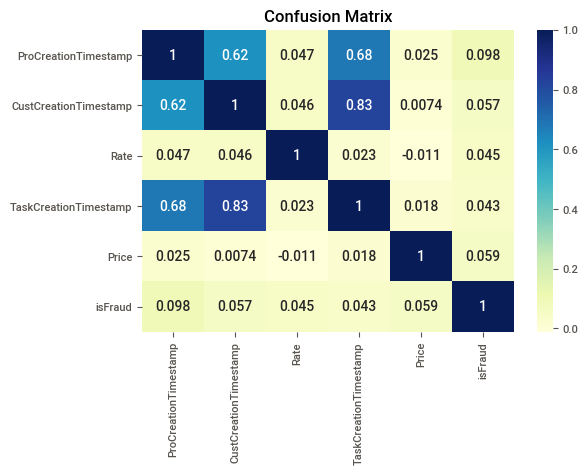

In [ ]:
# corrolation matrix
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=True, cmap="YlGnBu")
plt.title('Confusion Matrix')
plt.show()

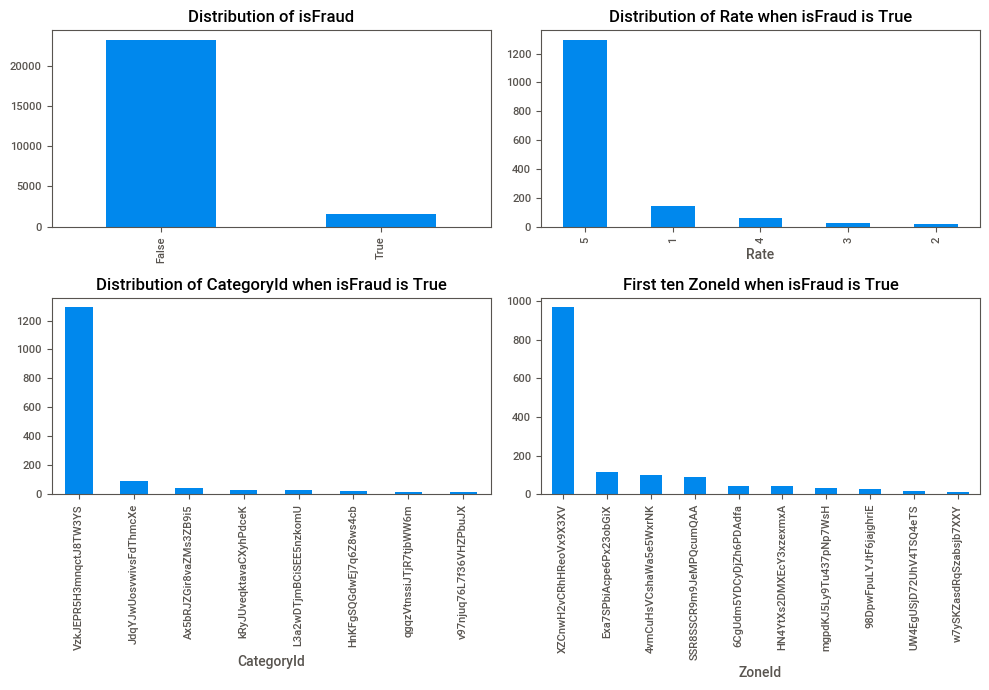

In [ ]:
df_fraud = df['isFraud'].value_counts()
df_rate = df[df['isFraud'] == 1].groupby('Rate')['isFraud'].count().sort_values(ascending=False)
df_catid = df[df['isFraud'] == 1].groupby('CategoryId')['isFraud'].count().sort_values(ascending=False)
df_zoneid = df[df['isFraud'] == 1].groupby('ZoneId')['isFraud'].count().sort_values(ascending=False)[:10]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,7))
df_fraud.plot(kind='bar', ax=axes[0,0], title='Distribution of isFraud')
df_rate.plot(kind='bar', ax=axes[0,1], title='Distribution of Rate when isFraud is True')
df_catid.plot(kind='bar',  ax=axes[1,0], title='Distribution of CategoryId when isFraud is True')
df_zoneid.plot(kind='bar', ax=axes[1,1], title='First ten ZoneId when isFraud is True')
fig.tight_layout()

In [ ]:
cond_true = df[df['isFraud'] == True]
cond_false = df[df['isFraud'] == False]
per = len(cond_true) / len(cond_false) * 100
print('Percentage of Fraud class: {}%'.format(round(per, 2)))

Percentage of Fraud class: 6.61%


In [ ]:
print('Percentage of NaN at each column in a DataFrame: ')
print(round(df.isnull().sum() * 100 / df.shape[0], 2)) 

Percentage of NaN at each column in a DataFrame: 
id                        0.00
ProId                     0.00
ProCreationTimestamp      0.00
CustId                    0.00
CustCreationTimestamp     0.00
Rate                      0.00
TaskCreationTimestamp     0.00
Price                    24.10
ServiceId                 0.00
CategoryId                0.00
ZoneId                    0.00
TaskState                 0.00
TargetProId              89.74
isFraud                   0.00
dtype: float64


***
# Feature Engineering

In [ ]:
def feature_engineering(df):
  # drop duplicate rows
  df = df.drop_duplicates()
  
  # handle missing values of Price column
  df['isMissed_Price'] = df['Price'].apply(lambda val:1 if np.isnan(val)==True else 0)
  df['Price'].fillna(round(df['Price'].mean(), 1), inplace=True)
  
  # drop rows with TaskState other than Finished
  cond = df[df['TaskState'] != 'Finished']
  df.drop(cond.index, inplace=True)
  
  # drop unwanted columns
  columns_must_drop = ['id', 'TargetProId', 'TaskState'] 
  df.drop(columns_must_drop, inplace = True, axis = 1)  
  
  # create new columns based on existing columns
  df['Cust-Pro']  = df['CustCreationTimestamp'] - df['ProCreationTimestamp']
  df['Task-Cust'] = df['TaskCreationTimestamp'] - df['CustCreationTimestamp']
  df['Task-Pro']  = df['TaskCreationTimestamp'] - df['ProCreationTimestamp']

  df['Pro+Cust']  = df['ProId'] + df['CustId']
  df['Serv+Cat']  = df['ServiceId'] + df['CategoryId']

  df['Price*Rate'] = df['Price'] * df['Rate']
  
  # change isFraud into integer rather than boolean
  df['isFraud'] = df['isFraud'].astype(int) 

  return df

In [ ]:
df = feature_engineering(df)
df.head()

,ProId,ProCreationTimestamp,CustId,CustCreationTimestamp,Rate,TaskCreationTimestamp,Price,ServiceId,CategoryId,ZoneId,isFraud,isMissed_Price,Cust-Pro,Task-Cust,Task-Pro,Pro+Cust,Serv+Cat,Price*Rate
0,vqUkxUDuEmB7gHWQvcYrBn,1552751751302,SgcxJApdnttAvEN9865TSZ,1565441404199,5,1565608270089,362000.0,bKv8JeCDhHBCe8SnfDcv66,VzkJEPR5H3mnqctJ8TW3YS,98DpwFpuLYJtF6jajghriE,0,0,12689652897,166865890,12856518787,vqUkxUDuEmB7gHWQvcYrBnSgcxJApdnttAvEN9865TSZ,bKv8JeCDhHBCe8SnfDcv66VzkJEPR5H3mnqctJ8TW3YS,1810000.0
1,KaLEhwzZxCQ7GjPmVwBVav,1558262535289,EveEDVPDDDq3Ljh3bg8Exn,1561655121208,5,1563280381472,513763.8,aegfi8HeWASAP6a9YkddeL,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,0,1,3392585919,1625260264,5017846183,KaLEhwzZxCQ7GjPmVwBVavEveEDVPDDDq3Ljh3bg8Exn,aegfi8HeWASAP6a9YkddeLVzkJEPR5H3mnqctJ8TW3YS,2568819.0
2,pybDYgTiCUv3Pv3WLgxKCM,1558538960723,mrDLWRmWuxGD7TVPAsD5X6,1545554406049,1,1566297337468,513763.8,uDHVz7XXXRCkGKWRUe2jKp,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,0,1,-12984554674,20742931419,7758376745,pybDYgTiCUv3Pv3WLgxKCMmrDLWRmWuxGD7TVPAsD5X6,uDHVz7XXXRCkGKWRUe2jKpVzkJEPR5H3mnqctJ8TW3YS,513763.8
3,zqPiDV33KwrMBZoyeQXMJW,1507727811649,aK3MnLeQywfLYMJJNyu7i8,1512288789660,4,1522825078700,513763.8,Jy7nZvUqvwDUhcAG59wPcg,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,0,1,4560978011,10536289040,15097267051,zqPiDV33KwrMBZoyeQXMJWaK3MnLeQywfLYMJJNyu7i8,Jy7nZvUqvwDUhcAG59wPcgVzkJEPR5H3mnqctJ8TW3YS,2055055.2
4,CR8z3ThPyzBKXFqqzemQAS,1560860808052,vHjzucgXFu9eA9YhuEeuk4,1561328838459,1,1564542737897,150000.0,f8o6yBmfeJiUTAmvpRCFAZ,VzkJEPR5H3mnqctJ8TW3YS,XZCnwH2vCRhHReoVx9X3XV,0,0,468030407,3213899438,3681929845,CR8z3ThPyzBKXFqqzemQASvHjzucgXFu9eA9YhuEeuk4,f8o6yBmfeJiUTAmvpRCFAZVzkJEPR5H3mnqctJ8TW3YS,150000.0


***
# Train, Validation and Test sets


In [ ]:
# define target column
target = 'isFraud'
# define categorical columns
cat_features = df[['ProId', 'CustId', 'ServiceId', 'CategoryId', 'ZoneId', 'Pro+Cust', 'Serv+Cat']] 

# define features
X = df.loc[:, df.columns != target]
# define label 
y = df[target]

# separate train from validation and test sets
X_train, X_valtest, y_train, y_valtest = train_test_split(X,
                                                          y,
                                                          stratify = y,
                                                          random_state = 1,
                                                          test_size = 0.4)
# seperate evenly validation and test set
X_val, X_test, y_val, y_test = train_test_split(X_valtest, 
                                                y_valtest,
                                                stratify = y_valtest, 
                                                random_state = 1, 
                                                test_size = 0.5)

***
# Hyper Parameter Tuning

In [ ]:
def objective(trial):
  # parameters
  param = {
      "objective": trial.suggest_categorical("objective", ["Logloss"]),
      "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
      "depth": trial.suggest_int("depth", 1, 12),
      "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
      "bootstrap_type": trial.suggest_categorical(
          "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
      ),
      "used_ram_limit": "3gb"
  }

  if param["bootstrap_type"] == "Bayesian":
      param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
  elif param["bootstrap_type"] == "Bernoulli":
      param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

  # catboost model
  model = cb.CatBoostClassifier(**param, 
                                cat_features = cat_features, 
                                class_weights = [0.06, 0.94])
  # train model
  model.fit(X_train, 
            y_train, 
            eval_set = [(X_val, y_val)], 
            verbose = 0, 
            early_stopping_rounds = 10)

  # predict
  preds = model.predict(X_val)
  pred_labels = np.rint(preds)

  # metric
  mcc = matthews_corrcoef(y_val, pred_labels)

  return mcc

In [ ]:
# optuna optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, timeout=600)

[I 2021-03-21 18:46:26,725] A new study created in memory with name: no-name-2130e442-5cf9-4d8d-b184-266afb0558c4
[I 2021-03-21 18:46:29,085] Trial 0 finished with value: 0.44007341210648065 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.033148082426560366, 'depth': 2, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.44007341210648065.
[I 2021-03-21 18:46:32,273] Trial 1 finished with value: 0.460040230896939 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.09944866409719146, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.460040230896939.
[I 2021-03-21 18:46:32,624] Trial 2 finished with value: 0.34823645227594346 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.015933999120887565, 'depth': 3, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.30604584058966733}. Best is trial 1 with value: 0.460040230896939.
[I 2021-03-21 18:46:33,66

In [ ]:
# best trail result
print("Number of finished trials: {}".format(len(study.trials)))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 10
Best trial:
  Value: 0.47421401624482057
  Params: 
    objective: Logloss
    colsample_bylevel: 0.06078150121055481
    depth: 8
    boosting_type: Plain
    bootstrap_type: Bernoulli
    subsample: 0.3750086556665708


In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

***
# Train with best Hyperparameters

In [ ]:
# concatenate train and validation sets for training
X_trainval = pd.concat([X_train, X_val], axis=0, ignore_index=False, sort=False)
y_trainval = pd.concat([y_train, y_val], axis=0, ignore_index=False, sort=False)

In [ ]:
# size of new training X and y
print('Shape of X_train:    ', X_train.shape)
print('Shape of X_val:      ', X_val.shape)
print('Shape of X_trainval: ', X_trainval.shape)

print('------------------------------')

print('Shape of y_train:    ', y_train.shape)
print('Shape of y_val:      ', y_val.shape)
print('Shape of y_trainval: ', y_trainval.shape)

Shape of X_train:     (14911, 17)
Shape of X_val:       (4971, 17)
Shape of X_trainval:  (19882, 17)
------------------------------
Shape of y_train:     (14911,)
Shape of y_val:       (4971,)
Shape of y_trainval:  (19882,)


In [ ]:
# define train and test sets
train_dataset = Pool(data = X_trainval, 
                     label = y_trainval,
                     cat_features = cat_features)

test_dataset = Pool(data = X_test, 
                    label = y_test,
                    cat_features = cat_features)

In [ ]:
# define catboost classifier model
model = CatBoostClassifier(
    iterations = 100, 
    class_weights = [0.06, 0.94],
    objective = 'Logloss',
    colsample_bylevel = 0.1,
    depth = 7,
    boosting_type = 'Plain',
    bootstrap_type = 'MVS',
    early_stopping_rounds = 10)

In [ ]:
# train on model
model.fit(train_dataset)

Learning rate set to 0.305054
0:	learn: 0.6440118	total: 8.32ms	remaining: 824ms
1:	learn: 0.6251399	total: 12.7ms	remaining: 622ms
2:	learn: 0.5959564	total: 17ms	remaining: 549ms
3:	learn: 0.5113620	total: 28.1ms	remaining: 674ms
4:	learn: 0.4818290	total: 33.4ms	remaining: 634ms
5:	learn: 0.4715906	total: 39.2ms	remaining: 614ms
6:	learn: 0.4479101	total: 48.6ms	remaining: 646ms
7:	learn: 0.4354277	total: 59.1ms	remaining: 679ms
8:	learn: 0.4168347	total: 66.2ms	remaining: 669ms
9:	learn: 0.4015639	total: 71.2ms	remaining: 641ms
10:	learn: 0.3955058	total: 75.9ms	remaining: 614ms
11:	learn: 0.3868962	total: 82.9ms	remaining: 608ms
12:	learn: 0.3795504	total: 89ms	remaining: 596ms
13:	learn: 0.3795440	total: 92.1ms	remaining: 566ms
14:	learn: 0.3747937	total: 98ms	remaining: 556ms
15:	learn: 0.3684136	total: 104ms	remaining: 545ms
16:	learn: 0.3684093	total: 106ms	remaining: 520ms
17:	learn: 0.3620899	total: 113ms	remaining: 517ms
18:	learn: 0.3611862	total: 117ms	remaining: 500ms
19

In [ ]:
def plot_feature_importance(importance, names):
    
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    # Create a DataFrame using a Dictionary
    data = {'feature_names':feature_names, 'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    # Define size of bar plot
    plt.figure(figsize=(10,8))
    # Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

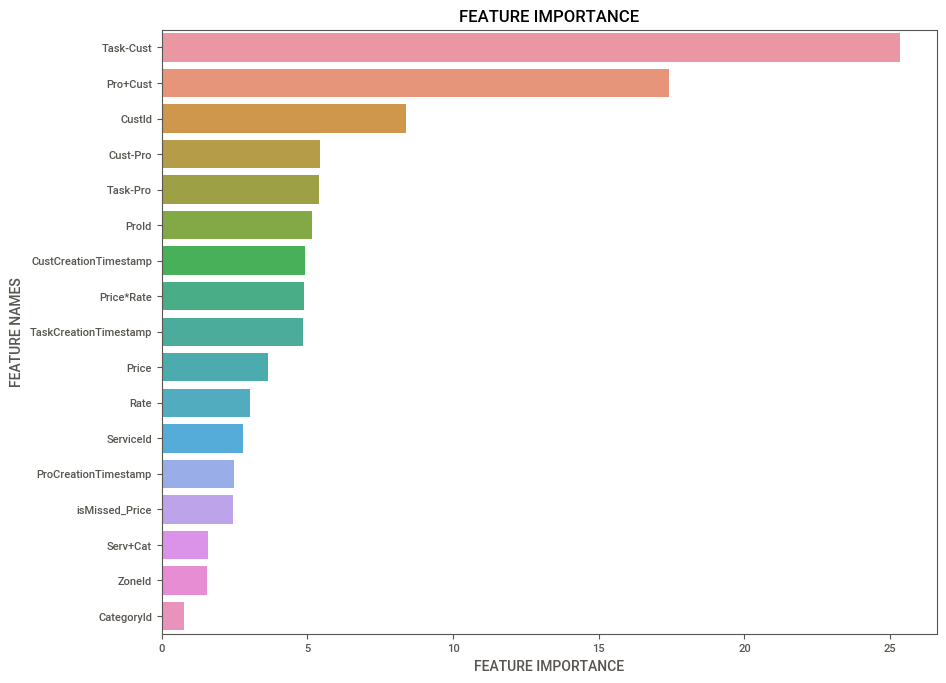

In [ ]:
# plot the feature importance plot
plot_feature_importance(model.get_feature_importance(train_dataset), X_train.columns)

*** 
# Evaluation

In [ ]:
# predict on train and test sets
pred_train = model.predict(train_dataset)
pred_test  = model.predict(test_dataset)

### Evaluation on Train set

In [ ]:
fpr_train, tpr_train, thresh_train = metrics.roc_curve(y_trainval, pred_train)
auc_train = round(metrics.auc(fpr_train, tpr_train), 2)
mcc_train = round(matthews_corrcoef(y_trainval, pred_train), 2)
f1_train  = round(f1_score(y_trainval, pred_train, average='weighted'), 2)
rep_train = classification_report(y_trainval, pred_train)

print('Evaluation Metrics for Train set:\n')
print('AUC on train: {}'.format(auc_train))
print('MCC on train: {}'.format(mcc_train))
print('F1-score on train: {}\n'.format(f1_train))
print(rep_train)

Evaluation Metrics for Train set:

AUC on train: 0.94
MCC on train: 0.64
F1-score on train: 0.94

              precision    recall  f1-score   support

           0       1.00      0.93      0.96     18650
           1       0.47      0.95      0.63      1232

    accuracy                           0.93     19882
   macro avg       0.74      0.94      0.80     19882
weighted avg       0.96      0.93      0.94     19882



### Evaluation on Test set

In [ ]:
fpr_test, tpr_test, thresh_test = metrics.roc_curve(y_test, pred_test)
auc_test = round(metrics.auc(fpr_test, tpr_test), 2)
mcc_test = round(matthews_corrcoef(y_test, pred_test), 2)
f1_test  = round(f1_score(y_test, pred_test, average='weighted'), 2)
rep_test = classification_report(y_test, pred_test)

print('Evaluation Metrics on Test set:\n')
print('AUC on test: {}'.format(auc_test))
print('MCC on test: {}'.format(mcc_test))
print('F1-score on test: {}\n'.format(f1_test))
print(rep_test)

Evaluation Metrics on Test set:

AUC on test: 0.8
MCC on test: 0.49
F1-score on test: 0.93

              precision    recall  f1-score   support

           0       0.98      0.94      0.96      4663
           1       0.42      0.65      0.51       308

    accuracy                           0.92      4971
   macro avg       0.70      0.80      0.74      4971
weighted avg       0.94      0.92      0.93      4971

